# About

'''
date created: 2018-04-09

go from many csv files to a top k index fund return
'''

In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

# initial dates

In [2]:
df0 = pd.read_csv('../../datasets/crypto-index-fund/CryptoData.csv', parse_dates=True)

In [3]:
df0.date = pd.to_datetime(df0.date)

In [4]:
initialdate_per_coin = df0.groupby('symbol').date.min()
initialdate_per_coin.to_csv('output/initialdate_per_coin.csv')

In [5]:
coins_top10today = ['BTC', 'ETH', 'XRP', 'BCH', 'LTC', 
                   'EOS', 'ADA', 'XLM', 'MIOTA', 'NEO']
initialdate_per_coin.T[coins_top10today]

symbol
BTC     2013-04-28
ETH     2015-08-07
XRP     2013-08-04
BCH     2017-07-23
LTC     2013-04-28
EOS     2017-07-01
ADA     2017-10-01
XLM     2014-08-05
MIOTA   2017-06-13
NEO     2016-09-09
Name: date, dtype: datetime64[ns]

In [6]:
del df0

# import 


In [7]:
df = pd.read_csv('../../datasets/crypto-index-fund/CryptoDataWide.csv', parse_dates=True)

/home/j/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (15,16,27,28,39,40,51,52,75,76,87,88,99,100,111,112,123,124,135,136,147,148,159,160,171,172,183,184,195,196,207,208,219,220,231,232,243,244,255,256,267,268,279,280,291,292,303,304,315,316,327,328,339,340,351,352,363,364,375,376,387,388,399,400,411,412,423,424,435,436,447,448,459,460,471,472,483,484,495,496,507,508,519,520,531,532,543,544,555,556,567,568,579,580,591,592,603,604,615,616,627,628,639,640,651,652,663,664,675,676,687,688,699,700,711,712,723,724,735,736,747,748,759,760,771,772,783,784,795,796,807,808,819,820,831,832,843,844,855,856,867,868,879,880,891,892,903,904,915,916,927,928,939,940,951,952,963,964,975,976,987,988,999,1000,1011,1012,1023,1024,1035,1036,1047,1048,1059,1060,1071,1072,1083,1084,1095,1096,1107,1108,1119,1120,1131,1132,1143,1144,1155,1156,1167,1168,1179,1180,1191,1192,1203,1204,1215,1216,1227,1228,1239,1240,1251,1252,1263,1264,1275,1276,1287,1288,1299,130

In [8]:
# index date
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [9]:
# begin at the start of a month
# och gör det att binarizer inte ger summa > 10 för dom första raderna? ngn bugg i den annars. 

# df = df.loc['2013-05-08':] #testa utan denna

# create matrices: price, mcap, volume

In [10]:
price_mat = df.filter(regex='^open.').fillna(0)
mcap_mat = df.filter(regex='^market').fillna(0)
volumes = df.filter(regex='^volume').fillna(0)

In [11]:
names = [n.replace('open.', '') for n in price_mat.columns]

In [12]:
price_mat.columns = names
mcap_mat.columns = names
volumes.columns = names

In [13]:
T = price_mat.shape[0]
nr_coins = price_mat.shape[1]
price_mat.shape

(1810, 1562)

In [14]:
assert mcap_mat.shape == price_mat.shape

todo: gör dictionary med name & symbol. jag föredrar symbol. 

## check

In [15]:
# comparisons below => looked ok 
mcap_mat.loc['2018-04-01', 'Bitcoin'], #116889698943 from online 
price_mat.loc['2018-04-01', 'Bitcoin'] # from online $6,895.74
mcap_mat.loc['2018-04-01', 'Litecoin'] # $6,440,675,643from online
price_mat.loc['2018-04-01', 'Litecoin'] # $115.25      from online
mcap_mat.loc['2018-04-01', 'Ripple'] #  $19,620,488,346  from online
price_mat.loc['2018-04-01', 'Ripple'] # $0.50      from online

0.51385400000000003

In [16]:
# compare all coins last 5 days with coinmarketcap.com
# price_mat.tail()
# mcap_mat.tai()

comparing with https://coinmarketcap.com/historical/20180408/ we have the correct cols now: market cap is 45 million USD and our dataset tells us 36 million so that's ok. 

In [17]:
if True==0:
    price_mat['Ethereum'].plot()
    plt.title('Ethereum price')
    plt.show()

For more checks, see coins2_20180415_1017.html

# monthly

we use monthly prices

In [18]:
# backup
daily_price_mat = price_mat
daily_mcap_mat = mcap_mat

month_price_mat = daily_price_mat.resample('M', convention='start').asfreq()
month_mcap_mat = daily_mcap_mat.resample('M', convention='start').asfreq()

In [19]:
# monthly data: the 10th
#month_price_mat = daily_price_mat.loc[daily_price_mat.index.day == 10]
#month_mcap_mat = daily_mcap_mat.loc[daily_mcap_mat.index.day == 10]

In [20]:
# do note the freq
daily_mcap_mat.resample('M').asfreq().index

DatetimeIndex(['2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
               '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
      

In [21]:
# choose 
freq = 'Monthly'

if freq == 'Monthly':
    price_mat = month_price_mat
    mcap_mat = month_mcap_mat
else:
    price_mat = daily_price_mat
    mcap_mat = daily_mcap_mat

In [22]:
mcap_mat.index.freq

<MonthEnd>

# choose nr of coins in the fund

In [23]:
p = 10 

# create B and W matrices

fundret = return matrix * weights.shift(1)
fundret = fundret.T.sum()
måste vara korrekt. 
weigths = mcap * binary (& sen normera). 

B matrix selects the top 10 coins, and contains only ones and zeroes - each row summing to 10.

W is a matrix with how much weights a certain coin give to the fund - each row summing to 1.

In [24]:
def top_binarizer(row, p):
    """
    Return 1 if a coin's mcap is within top p=10
    return 0 otherwise
    """
    t = p-1
    row = pd.Series(row) #maybe not needed but safer 
    #row.nlargest(5) # does not work very strange
    row_sorted = row.sort_values(ascending=False)
    #threshold = row_sorted.head(p).min() #11th value
    threshold = row_sorted[t] #10th value
    coins = row_sorted[0:t].index
    coins, threshold #check
    #Give a zero if a coin's mcap is less than threshold:
    binary = (row.values >= threshold).astype('int')
    return binary
# todo later: create a warning if two have identical market cap because nlargest just takes on eof them 

In [25]:
## all of the above steps "current script" in a few functions

def create_wbl(mcap_mat, p):
    """
    input market cap matrix, and p
    output for a top p fund: weights matrix (w), binary matrix (b), and list of coins (c)
    """
    # binary matrix selects coins:
    b = mcap_mat.apply(top_binarizer, p=p, axis=1)
    # mcap of the selected:
    marketcap_sel = mcap_mat.fillna(0) * b#.shift(-1) # shift +1 or -1
    # normalize by row:
    w = marketcap_sel.div(marketcap_sel.sum(axis=1), axis=0)    
    return w, b

In [26]:
# create w and b and coin list
w_mat, b_mat = create_wbl(mcap_mat, p=10)

# two choices:
# a
# use everything in mcap except last row which is NA 
# (due to .resample selects last day)
# w_mat, b_mat = create_wbl(mcap_mat.iloc[:-1], p=10)
# b
# w_mat, b_mat = create_wbl(mcap_mat, p=10)
# use >1 instead of >0 in coins_infund below

coins_all = b_mat.sum().index
coins_infund = coins_all[b_mat.sum() > 1]
print("Coins that once has been in top 10 \n", coins_infund)

Coins that once has been in top 10 
 Index(['Bitcoin', 'Ethereum', 'Ripple', 'Bitcoin Cash', 'EOS', 'Litecoin',
       'Cardano', 'Stellar', 'NEO', 'IOTA', 'Monero', 'Dash', 'NEM',
       'Ethereum Classic', 'Lisk', 'Bitcoin Gold', 'Steem', 'Bytecoin',
       'BitShares', 'DigixDAO', 'Stratis', 'Dogecoin', 'Waves', 'Augur',
       'Golem', 'Factom', 'Nxt', 'MaidSafeCoin', 'Emercoin', 'Peercoin',
       'Feathercoin', 'Counterparty', 'Namecoin', 'BlackCoin', 'Primecoin',
       'Omni', 'BitConnect', 'Auroracoin', 'Novacoin', 'Terracoin',
       'WorldCoin', 'Digitalcoin', 'PayCoin', 'Ixcoin', 'Quark', 'Bullion',
       'Megacoin', 'Freicoin', 'Yacoin', 'Mincoin', 'Infinitecoin'],
      dtype='object')


In [27]:
# assert monthly data
assert mcap_mat.shape[0] < 100

# create fundret vector

`Fundret` $ = W \circ R$ & then sum each row. Here, W is the weight matrix and R is the return matrix. The $\circ$ is an element-wise multiplication, aka Hadamard product.

To get `Fundprice` we use $Price_t = 100 \cdot \exp({\sum_t return_t})$

In [28]:
def returns_calc(price_matrix, fill_na_0=True):
    """
    input price matrix. output returns matrix.
    """
    # make sure the .shift direction is correct
    returns_matrix = price_matrix / price_matrix.shift(1) - 1
    # first day is na 
    if fill_na_0 == True:
        returns_matrix = returns_matrix.fillna(0)    
    # replace inf with 0 <=> buying after 1 day of existence
    returns_matrix = returns_matrix.replace([np.inf, -np.inf], 0) 
    return returns_matrix

In [29]:
def fundret_calc(price_mat, mcap_mat, p):
    """
    input: p, the price matrix and market cap matrix
    output: return vector of the top p fund
    """
    # create W and B matrices
    w, b = create_wbl(mcap_mat=mcap_mat, p=p)
    # returns matrix
    r = returns_calc(price_mat)
    # fund return: w * r, element-wise & then sum by row
    wr =  w.shift(1).fillna(0).as_matrix() * r
    fundret = wr.T.sum()
    return fundret, w, b, r

förut hade jag 

r.replace([np.inf, -np.inf], 0) # akut lösning

In [30]:
def fundmcap_calc(price_mat, mcap_mat, p):
    fundret, w, b, r = fundret_calc(price_mat, mcap_mat, p)
    wm = w.fillna(0).as_matrix() * mcap_mat
    bm = b.fillna(0).as_matrix() * mcap_mat
    return wm.T.sum(), bm.T.sum()

In [31]:
assert (price_mat.index == mcap_mat.index).all()

In [32]:
fundret, w, b, r = fundret_calc(price_mat, mcap_mat, p=10)
fundret.name = 'Fund'
fundprice = 100*np.exp(fundret.cumsum())

fundmcap, fundmcap_binary = fundmcap_calc(price_mat, mcap_mat, p=10)

In [33]:
# check index have correct freq "<MonthEnd>"
w.index.freq, b.index.freq, r.index.freq

(<MonthEnd>, <MonthEnd>, <MonthEnd>)

we will never buy something with inf return (at zero price). i tried to handle this by shifting the weights matrix back one step, but it didnt work. 

In [34]:
def indexed_price(pricevector):
    # assume same direction 
    r = pricevector / pricevector.shift(1) - 1
    r = r.replace([np.inf, -np.inf], 0) # this implies you buy after 1 full day of existence, i.e. 12h or 24h after ico begins
    r = r.fillna(0)
    return 100*np.exp(r.cumsum())

In [35]:
def indexed_return(returnvector):
    # assume same direction 
    r = returnvector.replace([np.inf, -np.inf], 0) 
    r = r.fillna(0)
    return 100*np.exp(r.cumsum())

# handle bch and etc

---

# EDA

0). Calculate performance of top 3, 5, 6, 7, 8, 9 and 10.

Jacob did some initial calculations from my dataset and seams like top 10 is good. It’s also a “easy” sell according to me. When we decide on this to everything below : (Håkan and Jacob feel free to add to this list, according to below is what's essential for us to be able to sell this to Nasdaq, but I surely have missed some important points).

1). Total market cap covered by the fund, 5 years back until today show in graph with percentage.

A trend downwards shows that BTC and ETH is not sufficient to give a good market exposure - You need to buy more assets to “capture the market”.

2). Number of different coins in the top 10 last 5 years.

A high number shows that you need to be an active investor even if you only invest in top 10.

3).  Number of coins that has been in top 10 that today is out of top 50 and top 100 last 5 years.

A high number of coins going from top 10 to low ranks show that there is high risk with a buy and hold strategy in top 10 if you don’t actively manage your holding.

4). Number of coins that has been in top 10 that now is “dead” last 5 years.

A high number or any number show the market is highly volatile and immature.

5). Number of coins that has died last 5 years.

A high number show the market is highly volatile and immature and speak into the use case of getting lower volatility and active management.

6). Correlations on coins (data I’ve seen shows that there is less correlation in top 15 than there is on the general stock market). Not sure about dates here.

Low correlations means that you need to own several assets to capture the market and just holding one or two assets is not going to ensure good value capturing.

7). Monthly return compared : Index fund, BTC and ETH (show this in graphics where you show the actual percentage return each month for) (suggestion : start 2015 until today)

A higher percent of return on index fund is good for use case.

8). Monthly average return compared : Index fund, BTC and ETH  (suggestion : start 2015 until today)

A higher average return on index fund is good for our use case.

9). Yearly return compared : Index fund, BTC and ETH  (suggestion : start 2015 until today)

A higher return on index fund is good for our use case.

10). Yearly average return Index fund , BTC and ETH  (suggestion : start 2015 until today)

A higher average return on index fund is good for our use case.

11). Volatility Index fund, BTC and ETH  (suggestion : start 2015 until today)

Lower volatility on index fund is good for our use case.

12). Percent of trade volume captured by the fund compared to BTC and ETH (last 5 years)
13). Calculate difference between index fund trade volume and BTC + ETH trade volume last 3 years.

The difference is potential lost revenue opportunities for Nasdaq. People are trading assets they don’t give exposure to.

14). Number of in & outs in index (5 years)

The higher number the better.

15). Number of position changes in index (5 years)

The higher number the better.

14). Bonus : Potential hedge to stock, bond markets and other investments (?) Flight to safe haven. 

Are crypto and stocks anti-correlated? If so this is a big positive for our use case.

## coins in the fund

In [36]:
print("A top", p, "cryptofund has", len(coins_infund),
      "different coins in it -  with monthly rebalancing")

A top 10 cryptofund has 51 different coins in it -  with monthly rebalancing


In [37]:
coins_infund

Index(['Bitcoin', 'Ethereum', 'Ripple', 'Bitcoin Cash', 'EOS', 'Litecoin',
       'Cardano', 'Stellar', 'NEO', 'IOTA', 'Monero', 'Dash', 'NEM',
       'Ethereum Classic', 'Lisk', 'Bitcoin Gold', 'Steem', 'Bytecoin',
       'BitShares', 'DigixDAO', 'Stratis', 'Dogecoin', 'Waves', 'Augur',
       'Golem', 'Factom', 'Nxt', 'MaidSafeCoin', 'Emercoin', 'Peercoin',
       'Feathercoin', 'Counterparty', 'Namecoin', 'BlackCoin', 'Primecoin',
       'Omni', 'BitConnect', 'Auroracoin', 'Novacoin', 'Terracoin',
       'WorldCoin', 'Digitalcoin', 'PayCoin', 'Ixcoin', 'Quark', 'Bullion',
       'Megacoin', 'Freicoin', 'Yacoin', 'Mincoin', 'Infinitecoin'],
      dtype='object')

In [38]:
coins_top10 = mcap_mat.iloc[-2].sort_values(ascending=False).head(10).index.tolist()
coins_top10

['Bitcoin',
 'Ethereum',
 'Ripple',
 'Bitcoin Cash',
 'Litecoin',
 'EOS',
 'Cardano',
 'Stellar',
 'NEO',
 'IOTA']

In [39]:
coins_comp = ['Bitcoin', 'Ethereum', 'Litecoin', 'Ripple']

## prices: fund vs coins

In [40]:
# first date where nr of coins are 10
b[b.T.sum()==10].index.min()

Timestamp('2013-05-31 00:00:00', freq='M')

In [41]:
def fund_vs_coins(date, coins, logy=True):
    """
    Input date and list of coins.
    Oututs a plot
    """
    iprice_fund = 100*np.exp(fundret.loc[date:].cumsum()).shift(1).fillna(1) # tmp fix. todo make it nicer
    # iprice_fund = indexed_return(fundret.loc[date:]) # previous but didnt start@100
    
    iprice_coins = indexed_price(price_mat.loc[date:, coins])
    
    fund_and_coins = pd.concat([iprice_fund, iprice_coins], axis=1)
    
    return fund_and_coins.plot(logy=logy)

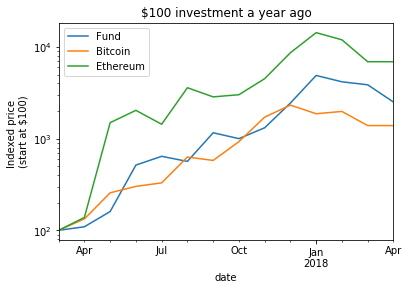

In [42]:
date = '2017-03'

fund_vs_coins(date, ['Bitcoin', 'Ethereum'])

plt.title('$100 investment a year ago')
plt.ylabel('Indexed price \n(start at $100)')
plt.savefig('output/price-fund_vs_coins_largesize.png', dpi=750)
plt.savefig('output/price-fund_vs_coins_smallsize.png')
plt.show()

In [43]:
100*np.exp(fundret.loc['2017-03':].cumsum())

date
2017-03-31     109.333447
2017-04-30     160.314541
2017-05-31     514.631838
2017-06-30     641.412194
2017-07-31     564.295309
2017-08-31    1158.439180
2017-09-30     999.531130
2017-10-31    1312.955660
2017-11-30    2444.332133
2017-12-31    4885.826740
2018-01-31    4165.192254
2018-02-28    3862.570039
2018-03-31    2506.205375
2018-04-30    2506.205375
Freq: M, Name: Fund, dtype: float64

In [44]:
100*np.exp(fundret.loc[date:].cumsum())

date
2017-03-31     109.333447
2017-04-30     160.314541
2017-05-31     514.631838
2017-06-30     641.412194
2017-07-31     564.295309
2017-08-31    1158.439180
2017-09-30     999.531130
2017-10-31    1312.955660
2017-11-30    2444.332133
2017-12-31    4885.826740
2018-01-31    4165.192254
2018-02-28    3862.570039
2018-03-31    2506.205375
2018-04-30    2506.205375
Freq: M, Name: Fund, dtype: float64

In [45]:
indexed_return(fundret.loc['2017-03':])

date
2017-03-31     109.333447
2017-04-30     160.314541
2017-05-31     514.631838
2017-06-30     641.412194
2017-07-31     564.295309
2017-08-31    1158.439180
2017-09-30     999.531130
2017-10-31    1312.955660
2017-11-30    2444.332133
2017-12-31    4885.826740
2018-01-31    4165.192254
2018-02-28    3862.570039
2018-03-31    2506.205375
2018-04-30    2506.205375
Freq: M, Name: Fund, dtype: float64

In [46]:
fundret.loc['2017-04':].cumsum()

date
2017-04-30    0.382735
2017-05-31    1.549049
2017-06-30    1.769270
2017-07-31    1.641175
2017-08-31    2.360426
2017-09-30    2.212884
2017-10-31    2.485634
2017-11-30    3.107125
2017-12-31    3.799691
2018-01-31    3.640115
2018-02-28    3.564686
2018-03-31    3.132123
2018-04-30    3.132123
Freq: M, Name: Fund, dtype: float64

In [47]:
indexed_price(price_mat.loc['2017-03':, 'Bitcoin'])

date
2017-03-31     100.000000
2017-04-30     133.318279
2017-05-31     256.558683
2017-06-30     301.363560
2017-07-31     329.156311
2017-08-31     629.655896
2017-09-30     578.060486
2017-10-31     926.635193
2017-11-30    1714.957193
2017-12-31    2319.364387
2018-01-31    1868.272684
2018-02-28    1978.412061
2018-03-31    1387.110832
2018-04-30    1387.110832
Freq: M, Name: Bitcoin, dtype: float64

In [48]:
plt.show()

In [49]:
indexed_return(fundret['2017-04':]).head()

date
2017-04-30     146.629002
2017-05-31     470.699365
2017-06-30     586.656887
2017-07-31     516.123224
2017-08-31    1059.546934
Freq: M, Name: Fund, dtype: float64

In [50]:
assert b.T.sum().median() == 10
# check it looks ok
#b.T.sum().plot()
#plt.xlabel('Nr of coins in the fund')
#plt.show()

## Summary statistics

Return, Vol, Return/Vol, etc.

In [51]:
fundmean = fundret.mean()*12
fundvol = fundret.std()*np.sqrt(12)
fundmean / fundvol

0.75209333877547646

In [52]:
print("Annualized mean:", fundmean*100, "%", 
      "Annualized vol:", fundvol*100, "%", 
     "(Based on monthly data.)")

Annualized mean: 177.33666752913754 % Annualized vol: 235.79077009 % (Based on monthly data.)


In [53]:
# day with max return 
fundret.idxmax(), fundret[fundret.idxmax()]

(Timestamp('2013-11-30 00:00:00', freq='M'), 4.9421235970540174)

In [54]:
rr = pd.concat([fundret, r[coins_top10]], axis=1)

In [55]:
if True == 0:
    rr_tmp = rr.replace(0, np.nan).apply([np.mean, np.std])
    rr_tmp.T.plot.barh()
    plt.xlabel('Monthly return (not annualized)')
    plt.show()
    #todo: annualize it

In [56]:
rr.to_csv('output/ret_annualized_forcalendarfig.csv')

In [57]:
# calc mean*12 and std*sqrt(12) since freq is monthly
def returns_vol_tbl(start, assets, end='2018-04', retmat=rr, T=12):
    """start with rr since it contains fund and coins returns.
    T=12 for monthly data and T=365 for daily data.
    output returnstable for a certain period.
    """
    # calc mean and vol
    returnstable = rr.loc[start:end, assets].apply([np.mean, np.std])
    # sqrt T rule
    returnstable = returnstable.multiply([T, np.sqrt(T)], axis=0)
    # rename
    returnstable.index = ['Mean return', 'Historical vol']
    # add sharpe
    rett = returnstable.T
    rett['Return / Vol'] = rett['Mean return'] / rett['Historical vol']
    returnstable = rett.T
    # round
    returnstable = returnstable.round(2)
    # rename
    return returnstable

In [58]:
assets_ = ['Fund', 'Bitcoin', 'Ethereum']

In [59]:
print(returns_vol_tbl(start='2017', assets=assets_))

                Fund  Bitcoin  Ethereum
Mean return     2.61     2.06      5.51
Historical vol  1.44     1.08      2.90
Return / Vol    1.81     1.89      1.90


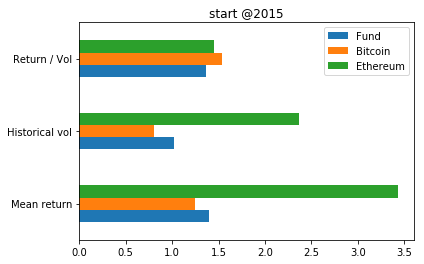

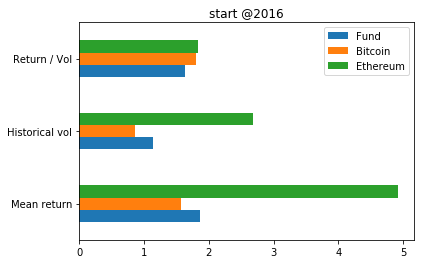

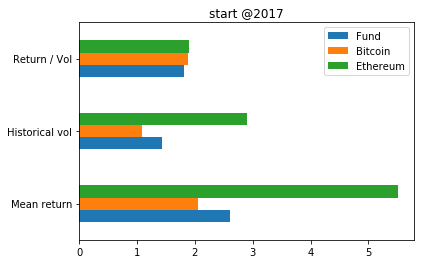

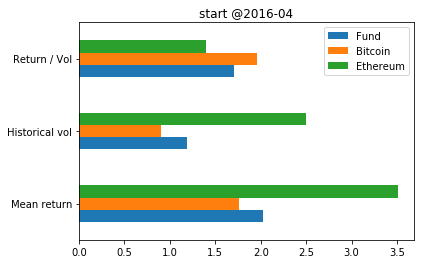

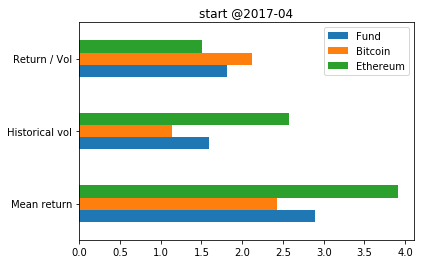

In [60]:
# compare sharpe ratios amon different years
startlist = ['2015', '2016', '2017', '2016-04', '2017-04']
for s in startlist:
    # print("\n start @", s)
    #print(returns_vol_tbl(start=s, assets=assets_))
    returns_vol_tbl(start=s, assets=assets_).plot.barh()
    plt.title("start @" + s)
    plt.show()

In [61]:
def sharpe(returnseries):
    # with risk free = 0
    # which does not matter since we compare among coins and their rf is arguably the same, although unknown
    mean = 12*np.mean(returnseries)
    vol = np.sqrt(12)*np.std(returnseries)
    return np.round(mean/vol, 3)

In [62]:
sharpelist = []
for coin in coins_top10:
    print(coin, sharpe(r[coin]))
    #sharpelist.append((coin, sharpe(r[coin])))
sharpe(rr.Fund)

Bitcoin 0.751
Ethereum 1.153
Ripple 0.873
Bitcoin Cash 0.426
Litecoin 0.547
EOS 0.499
Cardano 0.5
Stellar 0.857
NEO 0.777
IOTA 0.516


0.75800000000000001

## Returns

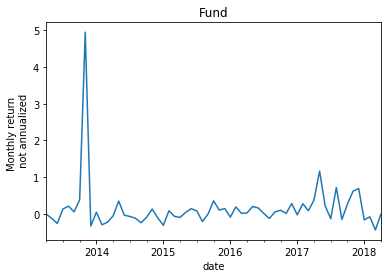

In [63]:
fundret.plot()
plt.title('Fund')
plt.ylabel('Monthly return \n not annualized')
plt.show()

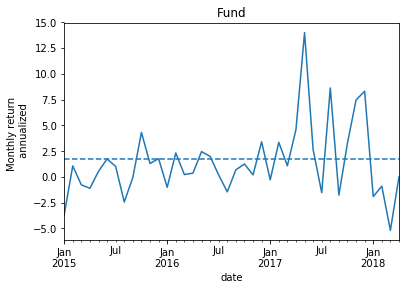

In [64]:
fundret_annualized = 12*fundret
fundret_annualized.loc['2015':].plot()
plt.title('Fund')
plt.ylabel('Monthly return \n annualized')
plt.axhline(y=fundret_annualized.mean(), ls='--')
plt.show()

In [65]:
fundret_annualized.to_csv('output/fundret_annualized.csv')

## Which coins are included?

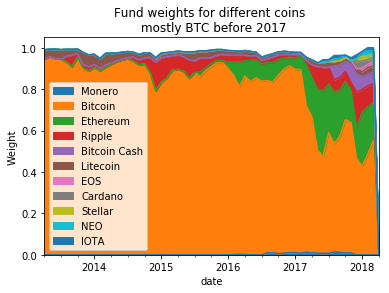

In [66]:
coins_thisplot = ['Monero'] + coins_top10 # incl monero so BTC is orange in fig
w[coins_thisplot].plot(kind='area', legend=True)
plt.title('Fund weights for different coins \n mostly BTC before 2017')
plt.ylabel('Weight')
plt.show()

In [67]:
k = 10

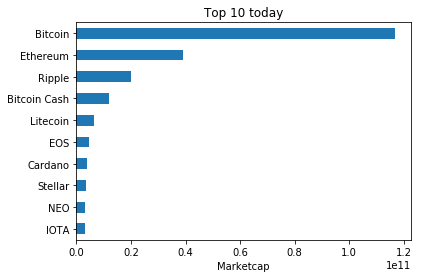

In [68]:
# current top 10
mcap_mat.iloc[-2,:].sort_values(ascending=True).tail(k).plot.barh()
plt.title('Top ' + str(k) + ' today')
plt.xlabel('Marketcap')
plt.show()

In [69]:
# top k on a certain date
date = '2014-03'
#mcap_mat.loc[date,:].sort_values(ascending=True).tail(k).plot.barh()
#plt.title('Top ' + str(k) + ' on ' + date)
#plt.xlabel('Marketcap')
#plt.show()
# todo: fix this later.

## Correlations

In [70]:
def corrplot(corr, annot=False):
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio

    return sns.heatmap(corr, mask=mask, annot=annot, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [71]:
# last 3y
start_date = '2015-04'
end_date = '2018-04'

## coins in fund (monthly data)

In [72]:
len(coins_infund)

51

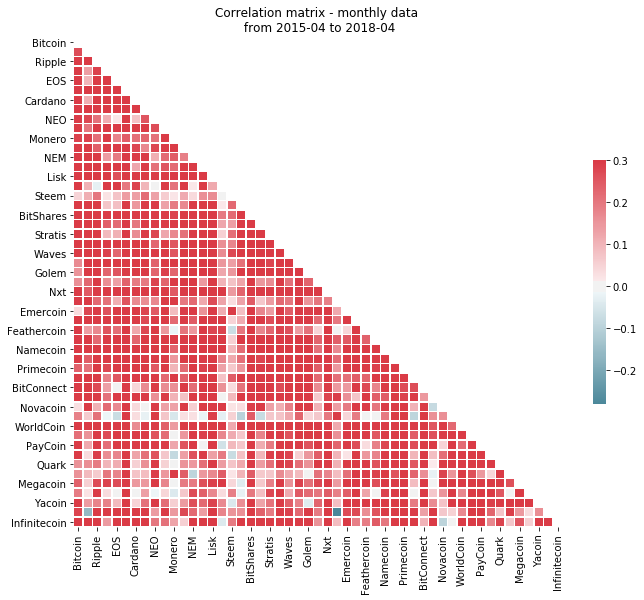

In [73]:
# todo compute rolling corr matrix and plot
corrplot(corr=r[coins_infund].loc[start_date:end_date].corr())
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.show()

## top 10 (monthly data)

In [74]:
rr.tail(3)

,Fund,Bitcoin,Ethereum,Ripple,Bitcoin Cash,Litecoin,EOS,Cardano,Stellar,NEO,IOTA
date,,,,,,,,,,,
2018-02-28,-0.075430,0.057280,-0.180340,-0.163985,-0.154670,0.314459,-0.255672,-0.366021,-0.262560,-0.020770,-0.112613
2018-03-31,-0.432563,-0.355071,-0.550078,-0.459491,-0.438878,-0.453976,-0.283705,-0.560176,-0.475489,-0.645807,-0.436548
2018-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


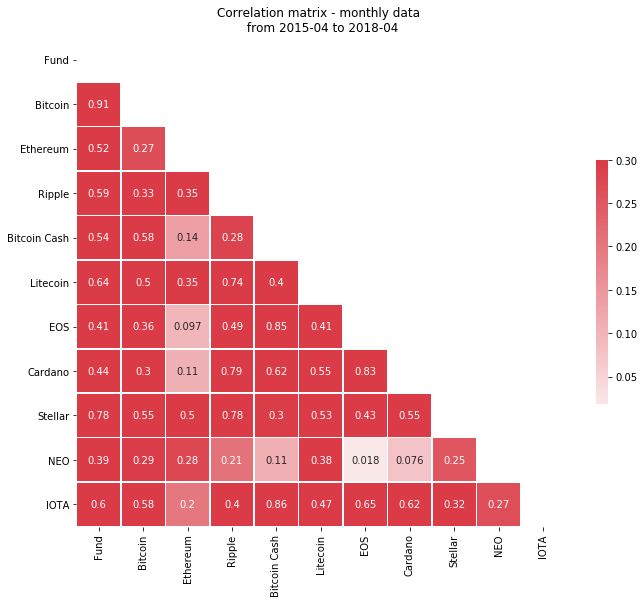

In [75]:
corrplot(rr.loc[start_date:end_date].corr(), annot=True)
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.show()

When I changed the `start_date` and `end_date` the correlation matrix did not change a lot. Some changes I did to 
these dates was to 

* have a have start and end within 1y of each other (aka a 1y window length)
* keep the 3y window length but move back in time, e.g. 2014 to 2017.

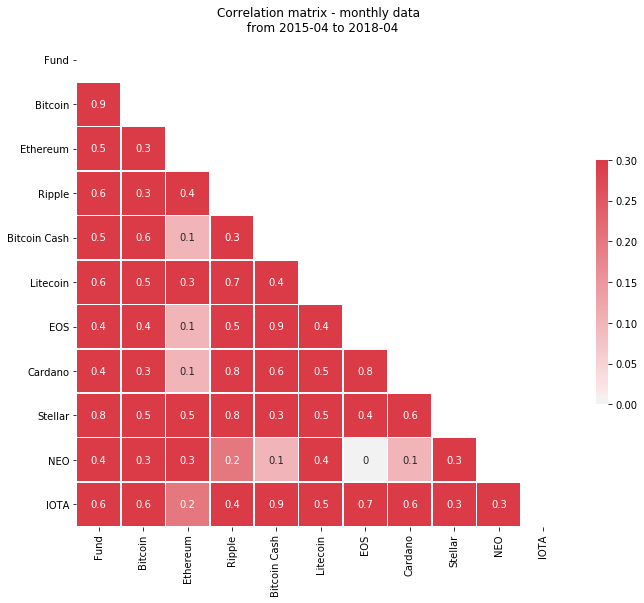

In [76]:
corrplot(rr.loc[start_date:].corr().round(1), annot=True)
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.savefig('output/corr-fund_top10-monthly_largesize.png', dpi=750)
plt.savefig('output/corr-fund_top10-monthly_smallsize.png')
plt.show()

There are statistical problems with using monthly data and 1y window, because then only 12 months are used to estimate the correlation - this sample can be considered small.

## Top 10 coins (daily data)

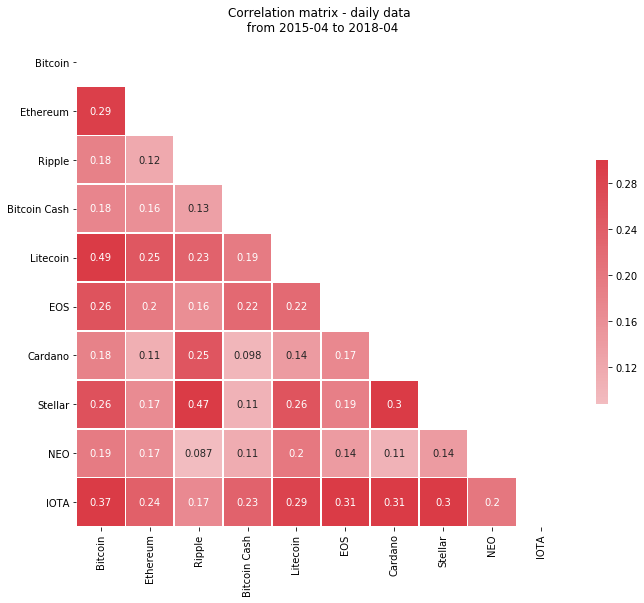

In [77]:
r_top10_mat = returns_calc(daily_price_mat[coins_top10])
corr_top10daily = r_top10_mat.loc[start_date:end_date].corr()
corrplot(corr_top10daily, annot=True)
plt.title('Correlation matrix - daily data \n from ' + start_date + ' to ' + end_date)
plt.show()

Note that the correlations are closer to zero with daily data than with monthly data. 

## Correlations over time

How do correlations change over time? For most financial assets they vary a lot over time.

/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12).corr(other=<DataFrame>)
  
/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12).corr(other=<DataFrame>)
  import sys


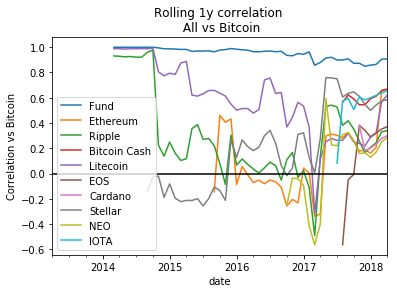

In [78]:
# rolling corr with fundret and all top10 coins
fund_and_coins = pd.concat([rr.iloc[:,0], #fund returns
                            rr.iloc[:,2:]], #all coins except btc
                           axis=1)
bitcoin_returns = rr.iloc[:,1]
rollcorr = pd.rolling_corr(bitcoin_returns, fund_and_coins, window=12)
rollcorr_old = pd.rolling_corr(rr.iloc[:,0], rr.iloc[:,1:], window=12) #when comparing fund vs coins
rollcorr.to_csv('output/rollcorr.csv', na_rep='NaN')
rollcorr.plot()
plt.ylabel('Correlation vs Bitcoin')
plt.title('Rolling 1y correlation \n All vs Bitcoin')
plt.axhline(y=0, color='k', ls='-')
plt.show()

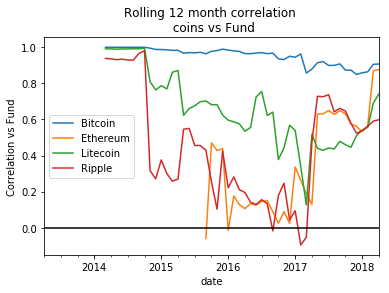

In [79]:
rollcorr_old[coins_comp].plot()
plt.ylabel('Correlation')
plt.title('Rolling 12 month correlation \n coins vs Fund')
plt.ylabel('Correlation vs Fund')
plt.axhline(y=0, color='k', ls='-')
plt.show()

Now we turn to daily data. For this set we do not have a fund. So here we calculate all correlations vs bitcoin. It will be a bit hard to compare monthly vs daily, since one with fund vs coins and another in bitcoin vs fund, but it's ok. (An alternative is to for monthly compare bitcoin vs fund&coins and for daily compare bitcoin & coins, but I think that's not as good).

In [80]:
rollcorr_daily = pd.rolling_corr(r_top10_mat.iloc[:,0], r_top10_mat.iloc[:,1:], window=250)
print("Monthly vs daily, in size: ", rollcorr.shape, rollcorr_daily.shape)

Monthly vs daily, in size:  (61, 10) (1810, 9)


/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=250).corr(other=<DataFrame>)
  """Entry point for launching an IPython kernel.


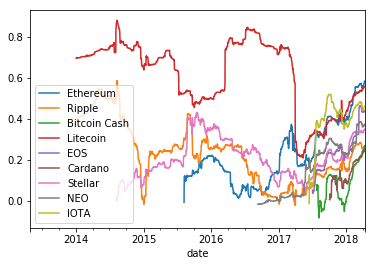

In [81]:
rollcorr_daily.plot()
plt.show()

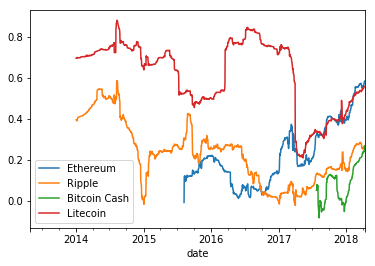

In [82]:
rollcorr_daily[['Ethereum', 'Ripple', 'Bitcoin Cash', 'Litecoin']].plot()
plt.show()

## correlation: crypto vs traditional finance

In [83]:
fin_p = pd.read_excel('data-financial/price_tradfinance.xlsx', index_col=0, parse_dates=True)

In [84]:
# index has freq None
fin_p.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2018-03-27', '2018-03-28', '2018-03-29', '2018-04-02',
               '2018-04-03', '2018-04-04', '2018-04-05', '2018-04-06',
               '2018-04-09', '2018-04-10'],
              dtype='datetime64[ns]', name='Date', length=1577, freq=None)

In [85]:
fin_p.columns = ['SP500', 'OMXS30', 'EURSTOXX', 'Gold']

In [86]:
# drop rows if any col has NA
fin_p.dropna(inplace=True)

In [87]:
fin_r = returns_calc(fin_p)

In [88]:
fin_r.isnull().sum()

SP500       0
OMXS30      0
EURSTOXX    0
Gold        0
dtype: int64

In [89]:
# reindex to inlcude all claendar days, using forward fill
#fin_r = fin_r.reindex(r_top10_mat.index, method='ffill')
fin_r = fin_r.reindex(df.resample('D').index, method='ffill') #df.resample('D').index
assert (fin_r.index == r_top10_mat.index).all()

/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
fin_r.index

DatetimeIndex(['2013-04-28', '2013-04-29', '2013-04-30', '2013-05-01',
               '2013-05-02', '2013-05-03', '2013-05-04', '2013-05-05',
               '2013-05-06', '2013-05-07',
               ...
               '2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05',
               '2018-04-06', '2018-04-07', '2018-04-08', '2018-04-09',
               '2018-04-10', '2018-04-11'],
              dtype='datetime64[ns]', name='date', length=1810, freq='D')

In [91]:
# create monthly data
#fin_r_monthly = fin_r.loc[fin_r.index.day == 10]
fin_r_monthly = fin_r.resample('M').asfreq()

In [92]:
# drop last row
fin_r_monthly = fin_r_monthly.iloc[:-1]

In [93]:
fin_r_monthly.shape

(60, 4)

### traditional - daily , 3y

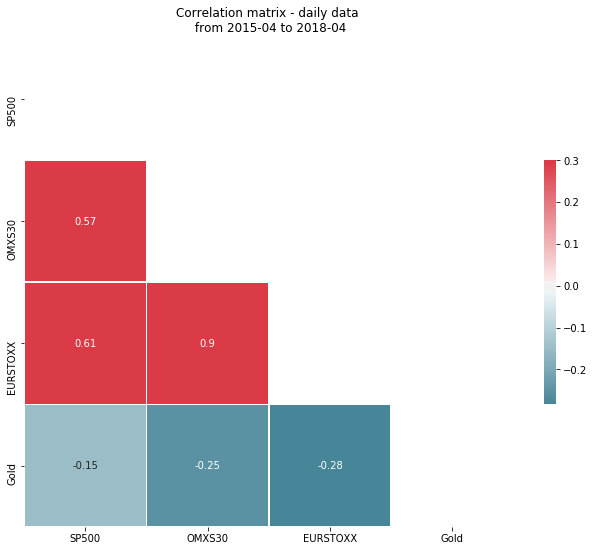

In [161]:
corrplot(fin_r.loc[start_date:end_date].corr(), annot=True)
plt.title('Correlation matrix - daily data \n from ' + start_date + ' to ' + end_date)
plt.show()

### traditional - monthly, 3y

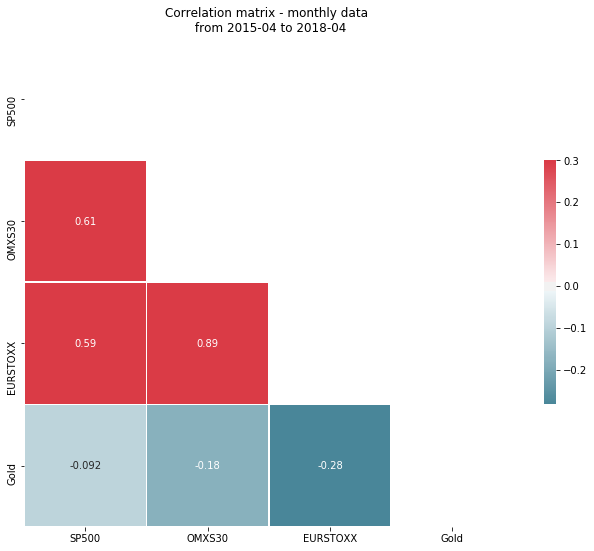

In [162]:
corrplot(fin_r_monthly.loc[start_date:end_date].corr(), annot=True)
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.show()

### traditional vs crypto, monthly

In [96]:
# Will not use `r_top10_mat` because it has .fillna(0) and that does not suit our needs here. 
r_top10_mat_na = returns_calc(price_mat[coins_top10], fill_na_0=False)

# concat the above with return for financial assets: both have monthly data
fin_coins_r = pd.concat([fin_r_monthly.loc[start_date:end_date], #financial assets
           r_top10_mat_na.loc[start_date:end_date], # top 10 crypto assets
                         fundret[start_date:end_date] # fund return
                        ], axis=1, join='inner')

In [97]:
fin_coins_r.shape, fin_r_monthly.index.min(), r_top10_mat_na.index.min(), fundret.index.min()

((36, 15),
 Timestamp('2013-04-30 00:00:00', freq='M'),
 Timestamp('2013-04-30 00:00:00', freq='M'),
 Timestamp('2013-04-30 00:00:00', freq='M'))

In [98]:
# monthly data
#assert (fin_coins_r.index == fin_r_monthly[start_date:end_date].index).all()
fin_coins_r.shape

(36, 15)

In [99]:
################################ todo incorrect shape now all of a sudden

In [100]:
print(len(fin_coins_r), " months")

36  months


In [101]:
# there are NAs
fin_coins_r.isnull().sum()

SP500            0
OMXS30           0
EURSTOXX         0
Gold             0
Bitcoin          0
Ethereum         4
Ripple           0
Bitcoin Cash    27
Litecoin         0
EOS             27
Cardano         30
Stellar          0
NEO             17
IOTA            26
Fund             0
dtype: int64

There are NAs. Those will be pairwise ignored. Todo: make sure by reading the docs again that this is how it is handled. You could also make a corrplot with dropped NAs.

In [102]:
corrplot(fin_coins_r.corr().round(1), annot=True)
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.savefig('output/corr-trad_coins_fund-monthly_largesize.png', dpi=750)
plt.savefig('output/corr-trad_coins_fund-monthly_smallsize.png')

corrplot(fin_coins_r.corr(), annot=False)
plt.title('Correlation matrix - monthly data \n from ' + start_date + ' to ' + end_date)
plt.savefig('output/corr-trad_coins_fund-monthly-annotFalse_largesize.png', dpi=750)
plt.savefig('output/corr-trad_coins_fund-monthly-annotFalse_smallsize.png')

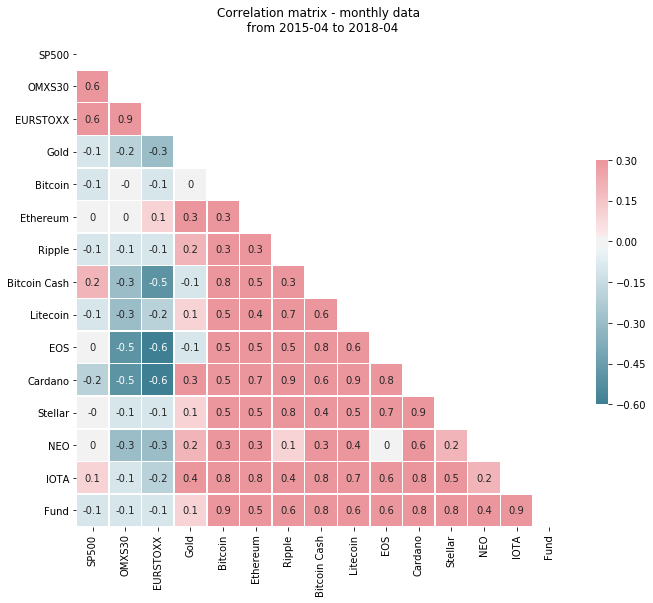

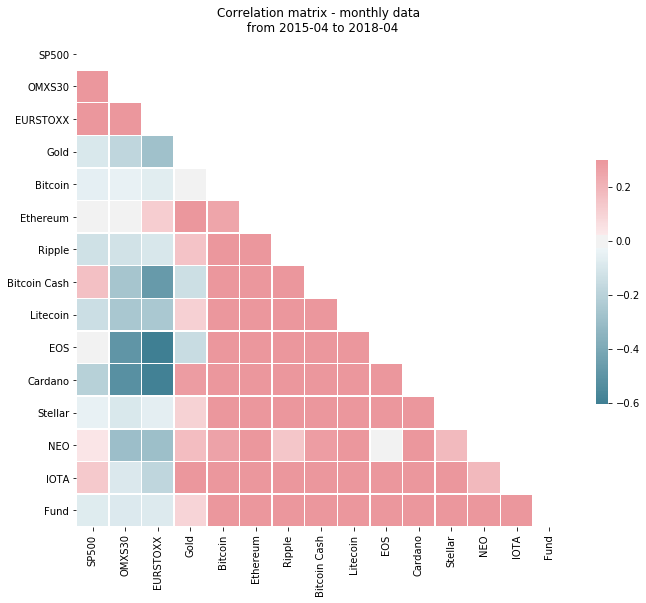

In [103]:
plt.show()

1. To compare coins vs coins, look in the lower right corner
2. To copmare traditional vs traditionl, look in the top left corner
3. to compare coins vs traditional, look in the left bottom corner

Take aways:

- traditional financial assets are _positively_ correlated with each other
- traditional financial assets are _negatively_ correlated with cryptocurrencies
- Bitcoin is positively correlated with all coins, and negatively correlated with traditional assets. 
- Ripple is uncorrelated with traditional financial assets & bitcoin, but positively correlated with all other coins
- Most coins are positevely correlated with each other (e.g bitcoin cash and litecoin) and some coins are negategly uncorrelated with each other (e.g. Ripple and bitcoin, monero and NEO)
- Any correlation below 1 leads to diversification. Close to zero is good, and negative is even better. Here, the correlations are between +.30 and -.45 which is pretty close to zero.


todo: make a for loop and print as files, then look at them superfast => nice movie.

### traditional vs crypto, rolling

In [104]:
selection = ['SP500', 'Gold', 'Fund', 'Ethereum']
pd.rolling_corr(fin_coins_r[selection], window=12).to_csv('output/rollcorr_tradvscoins.csv', na_rep='NaN')

/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12).corr(other=<DataFrame>,pairwise=True)
  


/home/j/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12).corr(other=<DataFrame>)
  


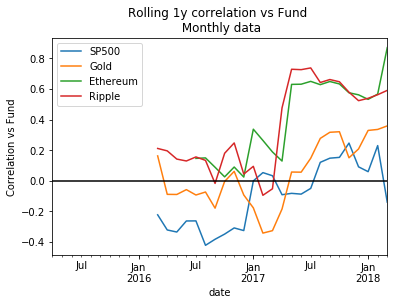

In [105]:
selection2 = ['SP500', 'Gold', 'Ethereum', 'Ripple']
pd.rolling_corr(fin_coins_r['Fund'], fin_coins_r[selection2], window=12).plot()
plt.title('Rolling 1y correlation vs Fund \n Monthly data')
plt.ylabel('Correlation vs Fund')
plt.axhline(y=0, color='k', ls='-')
plt.show()

Correlations are not stable over time, just like it usually is. It is important that they don't all go to 1 in some periods. Thus the output is good news.

## market cap covered by the fund

see the function for how `fundmcap` was created

In [106]:
# market cap of fund using W matrix
totmcap = mcap_mat.T.sum()
fund_fraq_mcap = fundmcap / totmcap

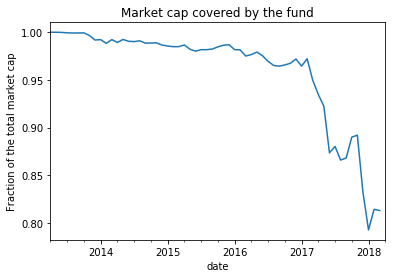

In [107]:
# market cap of fund using B matrix
fund_mcap_fraq_binary = fundmcap_binary / totmcap
fund_mcap_fraq_binary.name = 'Fund'
fund_mcap_fraq_binary.plot()
plt.ylabel('Fraction of the total market cap')
plt.title('Market cap covered by the fund')
plt.show()

In [108]:
btc_mcap_fraq = mcap_mat['Bitcoin'] / totmcap
eth_mcap_fraq = mcap_mat['Ethereum'] / totmcap

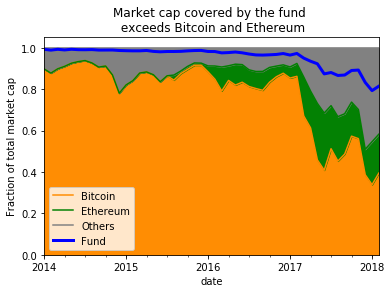

In [158]:
fraq_mcap_1 = pd.concat([btc_mcap_fraq, eth_mcap_fraq, 1-(btc_mcap_fraq+eth_mcap_fraq)], axis=1)
fraq_mcap_1.columns = ['Bitcoin', 'Ethereum', 'Others']
fraq_mcap_1['2014':'2018-02'].plot.area(color=['darkorange', 'g', 'grey'], alpha=0.99)
fund_mcap_fraq_binary['2014':'2018-02'].plot(color='b', linewidth=3)
plt.legend(list(fraq_volu_1.columns) + ['Fund'])
plt.ylabel('Fraction of total market cap')
plt.title('Market cap covered by the fund \n exceeds Bitcoin and Ethereum')
plt.savefig('output/mcap_fraq_largesize.png', dpi=750)
plt.savefig('output/mcap_fraq_smallsize.png')
plt.show()

In [181]:
import datetime as dt

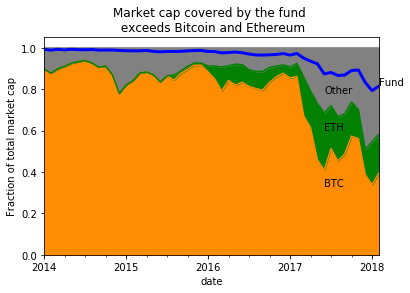

In [206]:
# plot
fraq_mcap_1['2014':'2018-02'].plot.area(color=['darkorange', 'g', 'grey'], alpha=0.99, legend=False)
fund_mcap_fraq_binary['2014':'2018-02'].plot(color='b', linewidth=3)

# labels
plt.ylabel('Fraction of total market cap')
plt.title('Market cap covered by the fund \n exceeds Bitcoin and Ethereum')

# annotate text
xpos = [
    dt.datetime(2017, 6, 1),
    dt.datetime(2017, 6, 1),
    dt.datetime(2017, 6, 1),
    dt.datetime(2018, 2, 1)]
plt.annotate('BTC', xy=(xpos[0], 0.33))
plt.annotate('ETH', xy=(xpos[1], 0.6))
plt.annotate('Other', xy=(xpos[2], 0.78))
plt.annotate('Fund', xy=(xpos[3], 0.82))

# save & show
plt.savefig('output/mcap_fraq_annot_largesize.png', dpi=750)
plt.show()

/home/j/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


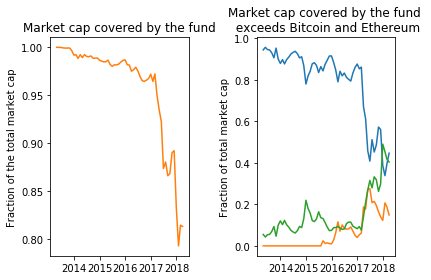

In [176]:
# todo plot them toghether but using an area plot

plt.subplot(1,2,1)
plt.plot(fund_mcap_fraq_binary)
plt.ylabel('Fraction of the total market cap')
plt.title('Market cap covered by the fund')

plt.subplot(1,2,2)
plt.plot(fraq_mcap_1)
plt.ylabel('Fraction of total market cap')
plt.title('Market cap covered by the fund \n exceeds Bitcoin and Ethereum')

plt.tight_layout()
plt.show()

## market cap for top 5 coins over time

it is not sufficient to hold only btc and eth to capture the market

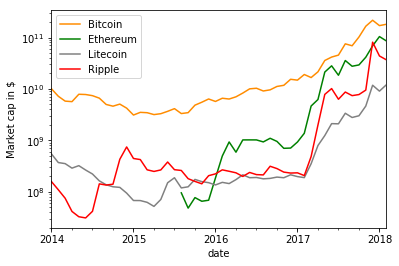

In [110]:
mcap_mat.loc['2014':'2018-02', coins_comp].plot(logy=True, color=['darkorange', 'g', 'grey', 'r'])
plt.ylabel('Market cap in $')
plt.show()

## 3).  Number of coins that has been in top 10 that today is out of top 50 and top 100 last 5 years

In [111]:
# last day is -2
coins_mcap_today = mcap_mat.iloc[-2]
coins_mcap_today = coins_mcap_today.sort_values(ascending=False)

In [112]:
# coins that are out of top 50 today
coins_mcap_today[50:].index

Index(['Aion', 'Ardor', 'Loopring', 'IOStoken', 'XPA', 'QASH', 'PIVX',
       'KuCoin Shares', 'Cryptonex', 'Ark',
       ...
       'Bubble', 'MSD', 'COMSA [XEM]', 'ODEM', 'STEX', 'InvestDigital',
       'Sphre AIR ', 'Pundi X', 'TechShares', 'W3Coin'],
      dtype='object', length=1512)

In [113]:
# coins that has once been in the fund
len(coins_infund)

51

In [114]:
intersection = set(coins_mcap_today[50:].index) & set(coins_infund)
len(intersection)

27

In [115]:
print(len(coins_infund), "different coins has been in top 10. Out of these,",
      len(intersection),"are now outside top 50." )

51 different coins has been in top 10. Out of these, 27 are now outside top 50.


todo: fix this something went wrong.

## coin switches within index

definition: A coin shift has occured in month t+1 if the set of selected coins for month t is not the same as month t+1.

this is calculated by comparing the B matrix with the lagged B matrix.

In [116]:
b_vs_bshift = b.shift(1) != b
fund_nr_coinswitches = b_vs_bshift.T.sum()
fund_nr_coinswitches = fund_nr_coinswitches[1:] # delete first row

The more coinswitches the harder it would be to replicate the portfolio on your own.

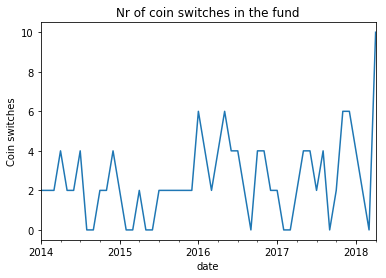

In [117]:
fund_nr_coinswitches['2014':].plot()
plt.title('Nr of coin switches in the fund')
plt.ylabel('Coin switches')
plt.show()

In [118]:
print("Nr of months with a coin switch:", sum(fund_nr_coinswitches > 0), "out of", len(fund_nr_coinswitches))
print("Median coins switches during a month:", fund_nr_coinswitches.median())

Nr of months with a coin switch: 49 out of 60
Median coins switches during a month: 2.0


In [119]:
print("example of a shift: NEM out, IOTA in")
print(b[b>0].iloc[-3,].sort_values()[0:11])
print(b[b>0].iloc[-4,].sort_values()[0:11])

example of a shift: NEM out, IOTA in
Bitcoin         1.0
Ethereum        1.0
Ripple          1.0
Bitcoin Cash    1.0
EOS             1.0
Litecoin        1.0
Cardano         1.0
Stellar         1.0
NEO             1.0
IOTA            1.0
Monero          NaN
Name: 2018-02-28 00:00:00, dtype: float64
Bitcoin         1.0
Ethereum        1.0
Ripple          1.0
Bitcoin Cash    1.0
EOS             1.0
Litecoin        1.0
Cardano         1.0
Stellar         1.0
NEO             1.0
NEM             1.0
IOTA            NaN
Name: 2018-01-31 00:00:00, dtype: float64


## rebalancing changes

begin with: delta weights. because this tells you how much there is to rebalance

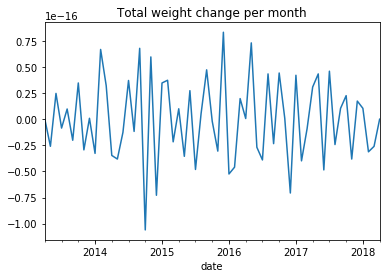

In [120]:
w_change = w - w.shift(1)
w_change[coins_infund].T.sum().plot()
plt.title('Total weight change per month')
plt.show()

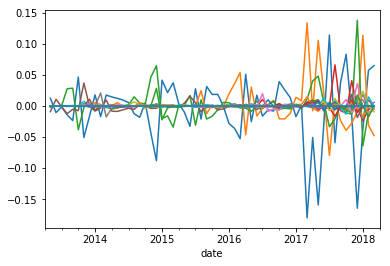

In [121]:
w_change = w - w.shift(1)
w_change[coins_infund].plot(legend=False)
plt.show()

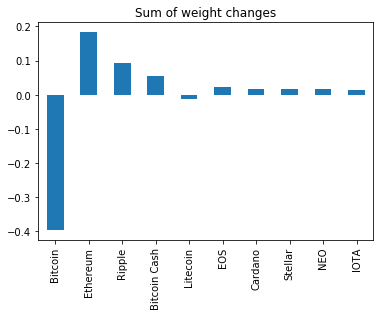

In [122]:
w_change[coins_top10].sum().plot.bar()
plt.title('Sum of weight changes')
plt.show()

Logisk output: över tid så har dom som ligger i top 10 ätit sig in i fonden, på bekostnad av btc.

## coin switches in and out of index

how often does a coin leave the top10?

In [123]:
# todo
# filter out the 10th mcap exactly. list that coin. if then sum series != series.shift(1)

In [124]:
list_pth_coin = []
for i in range(0, len(mcap_mat)):
    row = mcap_mat.iloc[i]
    coin_nr_p = row.sort_values(ascending=False).head(10).index[10-1]
    list_pth_coin.append(coin_nr_p)
list_pth_coin = pd.Series(list_pth_coin)

In [125]:
nr_switches = sum(list_pth_coin.shift(1) != list_pth_coin)
nr_switches = nr_switches - 1 # but the first one was NA
print("The number of months a coin at place 10 switched was",
      nr_switches.sum(), 
      "out of", len(mcap_mat), "months")

The number of months a coin at place 10 switched was 51 out of 61 months


## volumes

exchanges make money on trading volume

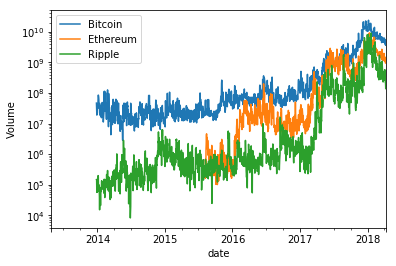

In [126]:
volumes[['Bitcoin', 'Ethereum', 'Ripple']].plot(logy=True)
plt.ylabel('Volume')
plt.show()

In [127]:
# monthly data
volume_m = volumes.resample('M').sum()

In [128]:
volume_m.to_csv('output/volume_monthly.csv', na_rep='NaN')

In [129]:
# created above
w_mat.shape, b_mat.shape


fundvolume_binary = b_mat.fillna(0).as_matrix() * volume_m

totvolume = volume_m.T.sum()
fraq_fundvolume_binary = fundvolume_binary / totvolume
fraq_fundvolume_binary.shape

/home/j/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:3033: RuntimeWarning: Cannot compare type 'Timestamp' with type 'str', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


(61, 1623)

In [130]:
volume_m.shape

(61, 1562)

In [131]:
totvolume.shape

(61,)

In [132]:
# w
# marketcap_sel.div(marketcap_sel.sum(axis=1), axis=0)

In [133]:
# fraction of volume for every coin
fraq_volume_m_coins = volume_m.div(volume_m.sum(axis=1), axis=0)

In [134]:
fraq_volume_m_sel = b_mat.as_matrix() * fraq_volume_m_coins
fraq_fund_volume_m = fraq_volume_m_sel.sum(axis=1)
#fraq_fund_volume_m.plot()
#plt.show()

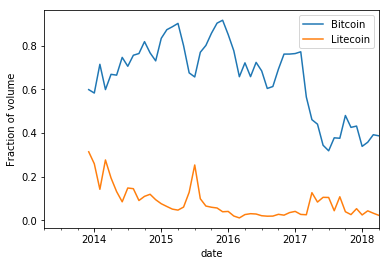

In [135]:
fraq_volume_m_coins[['Bitcoin', 'Litecoin']].plot()
plt.ylabel('Fraction of volume')
plt.show()

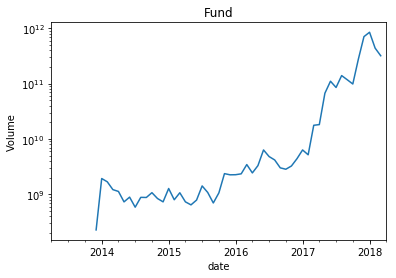

In [136]:
fundvolume_binary.T.sum().plot(logy=True)
plt.title('Fund')
plt.ylabel('Volume')
plt.show()

In [137]:
fundret.index

DatetimeIndex(['2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
               '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
      

In [138]:
fundvolume_binary.index

DatetimeIndex(['2013-04-30', '2013-05-31', '2013-06-30', '2013-07-31',
               '2013-08-31', '2013-09-30', '2013-10-31', '2013-11-30',
               '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-31', '2014-06-30', '2014-07-31',
               '2014-08-31', '2014-09-30', '2014-10-31', '2014-11-30',
               '2014-12-31', '2015-01-31', '2015-02-28', '2015-03-31',
               '2015-04-30', '2015-05-31', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-31', '2015-11-30',
               '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31',
               '2016-04-30', '2016-05-31', '2016-06-30', '2016-07-31',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
               '2016-12-31', '2017-01-31', '2017-02-28', '2017-03-31',
               '2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31',
               '2017-08-31', '2017-09-30', '2017-10-31', '2017-11-30',
      

In [139]:
# fraq_fund_volume_m['2014':].plot()

In [140]:
fraq_fund_volume_m.columns = 'Fund'

In [141]:
frac_volume_m = pd.concat([fraq_volume_m_coins, 
                           fraq_fund_volume_m], axis=1)

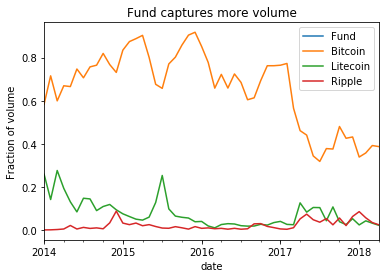

In [142]:
selection3 = ['Fund', 'Bitcoin', 'Litecoin', 'Ripple']
frac_volume_m.loc['2014':, selection3].plot()
plt.ylabel('Fraction of volume')
plt.title('Fund captures more volume')
plt.show()

In [143]:
# volumes_fraq = volumes.div(volumes.sum())

In [144]:
# volumes_fraq.tail(2).T.sum()

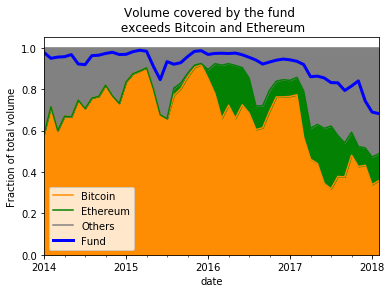

In [155]:
fraq_volu_1 = pd.concat([fraq_volume_m_coins[['Bitcoin', 'Ethereum']], 
                         1-fraq_volume_m_coins[['Bitcoin', 'Ethereum']].T.sum()], 
                        axis=1)
fraq_volu_1 = fraq_volu_1.loc['2014':'2018-02']
fraq_volu_1.columns = ['Bitcoin', 'Ethereum', 'Others']
fraq_volu_1.plot.area(color=['darkorange', 'g', 'grey'], alpha=0.99)
fraq_fund_volume_m['2014':'2018-02'].plot(color='b', linewidth=3)
plt.legend(list(fraq_volu_1.columns) + ['Fund'])
plt.ylabel('Fraction of total volume')
plt.title('Volume covered by the fund \n exceeds Bitcoin and Ethereum')
plt.savefig('output/volu_fraq_largesize.png', dpi=750)
plt.savefig('output/volu_fraq_smallsize.png')
# klippte vid 2018-02 för det såg bättre ut
plt.show()

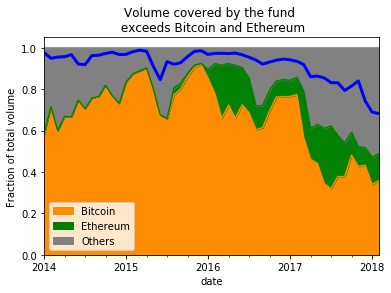